21546it [3:59:05,  1.50it/s]


step 0: train loss:  0.6921, val loss: nan
step 0: train accuracy:  49.51%, eval accuracy: 50.46%


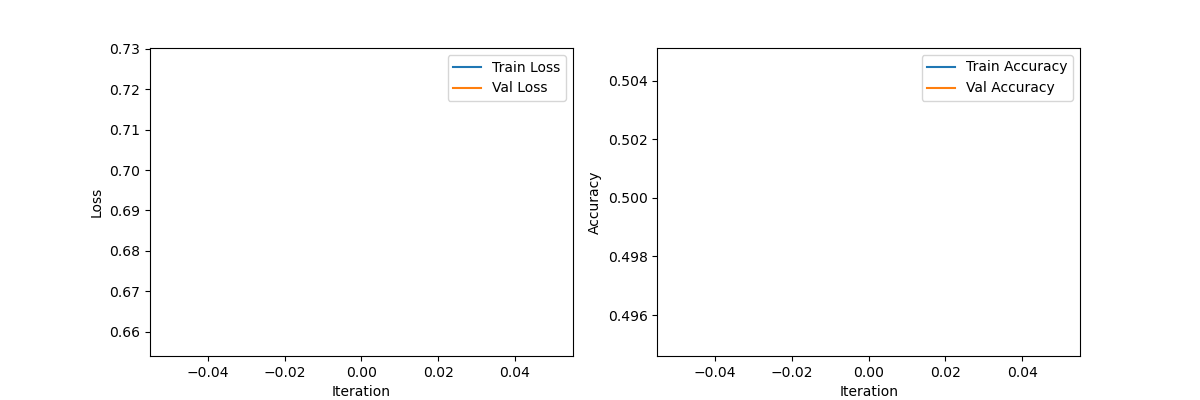

Iter [1/2000] - Elapsed Time: 16145.18s  Remaining Time: [32290362.77]


1971it [22:32,  1.46it/s]


Keyboard interrupt,
Final train loss: 0.6921, 
Final val loss: nan, 
Final train accuracy: 49.51%, 
Final val accuracy: 50.46%
Model saved!


In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from psutil import cpu_count
from torch.utils.data import DataLoader
from dataloader import PicklebotDataset, custom_collate
from mobilenet import MobileNetLarge2D, MobileNetSmall2D, MobileNetSmall3D,MobileNetLarge3D

%matplotlib widget

'''Balls are 0, strikes are 1'''

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#hyperparameters

learning_rate = 3e-4 #the paper quotes rmsprop with 0.1 lr, but we have a tiny batch size, and are using AdamW
batch_size = 2 #the paper quotes 128 images/chip, but with video we have to change this
max_iters = 2000
eval_interval = 50
weight_decay=0.0005
momentum=0.9
eps=np.sqrt(0.002) #From the pytorch blog post, "a reasonable approximation can be taken with the formula PyTorch_eps = sqrt(TF_eps)."

#annotations paths
train_annotations_file = '/workspace/picklebotdataset/train_labels.csv'
val_annotations_file = '/workspace/picklebotdataset/val_labels.csv'

#video paths
train_video_paths = '/workspace/picklebotdataset/train'
val_video_paths = '/workspace/picklebotdataset/val'

#annotations paths
train_annotations_file = '/home/hankhome/Documents/PythonProjects/picklebotdataset/sorted_labels.csv'
val_annotations_file = '/home/hankhome/Documents/PythonProjects/picklebotdataset/val_labels_lengths.csv'

#video paths
train_video_paths = '/home/hankhome/Documents/PythonProjects/picklebotdataset/train'
val_video_paths = '/home/hankhome/Documents/PythonProjects/picklebotdataset/val/'


#dataset     
transform = transforms.Normalize((0.5,), (0.5,))

train_dataset = PicklebotDataset(train_annotations_file,train_video_paths,transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,collate_fn=custom_collate,num_workers=cpu_count())
val_dataset = PicklebotDataset(val_annotations_file,val_video_paths,transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True,collate_fn=custom_collate,num_workers=cpu_count())

#model, optimizer, loss function
model = MobileNetSmall3D().to(device)

#for multi-gpu
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# optimizer = optim.RMSprop(params=model.parameters(),lr=learning_rate,weight_decay=weight_decay,momentum=momentum,eps=eps) #starting with AdamW for now. 
optimizer = optim.AdamW(params=model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=2)
scaler = GradScaler()
model_name = 'mobilenetsmall_3D_lambda' 

@torch.no_grad()
def estimate_loss():
    #evaluate the model
    model.eval()
    total_val_loss = 0.0
    num_val_batches = 0
    correct_predictions = 0

    #calculate the loss
    for val_features,val_labels in val_loader:
        val_features = val_features.to(device)
        val_labels = val_labels.to(torch.int64) #waiting to move to device until after forward pass, idk if this matters
        
        val_outputs = model(val_features)
        
        val_loss = criterion(val_outputs,val_labels.to(device))
        
        total_val_loss += val_loss.item()
        
        num_val_batches += 1        
        
        correct_predictions += calculate_accuracy(val_outputs,val_labels)
    
    avg_val_loss = total_val_loss / num_val_batches
    val_accuracy = correct_predictions / len(val_loader.dataset)
    return avg_val_loss, val_accuracy

def calculate_accuracy(outputs,labels):
    predicted_classes = torch.argmax(outputs,dim=1).to(labels.device)
    num_correct = torch.sum(predicted_classes == labels).item()
    return num_correct



#try except block so we can manually early stop while saving the model
#training loop
start_time = time.time()
train_losses = []set(train_labels[0].values.tolist()) == 
train_percent = []
val_losses = []
val_percent = []


#plot losses
plt.ion()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.legend()

#plot accuracy
ax2.plot(train_percent, label='Train Accuracy')
ax2.plot(val_percent, label='Val Accuracy')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy')
ax2.legend()


try:
    for iter in range(max_iters):
        
        model.train()
        train_correct = 0
        train_samples = 0
        #forward pass
        for batch_idx, (features,labels) in tqdm(enumerate(train_loader)):
            
            labels = labels.to(torch.int64)
            features = features.to(device)
            
            #zero the gradients
            optimizer.zero_grad(set_to_none=True)
            
            with autocast():
                outputs = model(features)
                loss = criterion(outputs,labels.to(device))
            
            #backprop & update weights

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            batch_correct = calculate_accuracy(outputs,labels)
            train_correct += batch_correct
            train_samples += len(labels)

        if iter % eval_interval == 0 or iter == max_iters - 1:
            
            #evaluate the model
            train_losses.append(loss.item()) #loss of the last batch
            train_percent.append(train_correct / train_samples)
            val_loss, val_accuracy = estimate_loss()
        
            val_losses.append(val_loss) #loss of the val batch
            val_percent.append(val_accuracy) #percent of correct predictions in the val batch

            print(f"step {iter}: train loss:  {loss:.4f}, val loss: {val_loss:.4f}")
            print(f"step {iter}: train accuracy:  {train_percent[-1]*100:.2f}%, eval accuracy: {val_percent[-1]*100:.2f}%")

            # #plot the losses
            ax1.plot(train_losses, label='Train Loss')
            ax1.plot(val_losses, label='Val Loss')

            #plot the accuracy
            ax2.plot(train_percent, label='Train Accuracy')
            ax2.plot(val_percent, label='Val Accuracy')


            fig.canvas.draw()
            fig.canvas.flush_events()
            plt.pause(0.001)


        elapsed = time.time() - start_time
        remaining_iters = max_iters - iter
        avg_time_per_iter = elapsed / (iter + 1)
        estimated_remaining_time = remaining_iters * avg_time_per_iter

        tqdm.write(f"Iter [{iter+1}/{max_iters}] - Elapsed Time: {elapsed:.2f}s  Remaining Time: [{estimated_remaining_time:.2f}]")
        if iter == max_iters -1:
            print("Training completed:") 
            print(f"Final train loss: {train_losses[-1]:.4f},")
            print(f"Final val loss: {val_losses[-1]:.4f}, ")
            print(f"Final train accuracy: {train_percent[-1]*100:.2f}%, ")
            print(f"Final val accuracy: {val_percent[-1]*100:.2f}%") 
            
except KeyboardInterrupt:
    print(f"Keyboard interrupt,\nFinal train loss: {train_losses[-1]:.4f}, ")
    print(f"Final val loss: {val_losses[-1]:.4f}, ")
    print(f"Final train accuracy: {train_percent[-1]*100:.2f}%, ")
    print(f"Final val accuracy: {val_percent[-1]*100:.2f}%")

finally:
    torch.save(model.state_dict(), f'{model_name}.pth')
    with open(f'{model_name}_train_losses.npy', 'wb') as f:
        np.save(f, np.array(train_losses))
    with open(f'{model_name}_val_losses.npy', 'wb') as f:
        np.save(f, np.array(val_losses))
    with open(f'{model_name}_train_percent.npy', 'wb') as f:
        np.save(f, np.array(train_percent))
    with open(f'{model_name}_val_percent.npy', 'wb') as f:
        np.save(f, np.array(val_percent))
    print(f"Model saved!") 
plt.ioff()

In [ ]:
'''This version of the program uses Nvidia Dali to load data, not torchvision.io.read_video,
   It should be substantially faster, especially with multiple gpus, perhaps a good setup 
   would be one to load the videos, one to run the training loop?'''

import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from psutil import cpu_count
from torch.utils.data import DataLoader
from dataloader import PicklebotDataset, custom_collate
from mobilenet import MobileNetLarge2D, MobileNetSmall2D, MobileNetSmall3D,MobileNetLarge3D
from helpers import 

%matplotlib widget

'''Balls are 0, strikes are 1'''

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#hyperparameters

learning_rate = 3e-4 #the paper quotes rmsprop with 0.1 lr, but we have a tiny batch size, and are using AdamW
batch_size = 2 #the paper quotes 128 images/chip, but with video we have to change this
max_iters = 2000
eval_interval = 50
weight_decay=0.0005
momentum=0.9
eps=np.sqrt(0.002) #From the pytorch blog post, "a reasonable approximation can be taken with the formula PyTorch_eps = sqrt(TF_eps)."

#annotations paths
train_annotations_file = '/workspace/picklebotdataset/train_labels.csv'
val_annotations_file = '/workspace/picklebotdataset/val_labels.csv'

#video paths
train_video_paths = '/workspace/picklebotdataset/train'
val_video_paths = '/workspace/picklebotdataset/val'

#annotations paths
train_annotations_file = '/home/hankhome/Documents/PythonProjects/picklebotdataset/sorted_labels.csv'
val_annotations_file = '/home/hankhome/Documents/PythonProjects/picklebotdataset/val_labels_lengths.csv'

#video paths
train_video_paths = '/home/hankhome/Documents/PythonProjects/picklebotdataset/train'
val_video_paths = '/home/hankhome/Documents/PythonProjects/picklebotdataset/val/'


#dataset     
transform = transforms.Normalize((0.5,), (0.5,))

train_dataset = PicklebotDataset(train_annotations_file,train_video_paths,transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,collate_fn=custom_collate,num_workers=cpu_count())
val_dataset = PicklebotDataset(val_annotations_file,val_video_paths,transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True,collate_fn=custom_collate,num_workers=cpu_count())

#model, optimizer, loss function
model = MobileNetSmall3D().to(device)

#for multi-gpu
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# optimizer = optim.RMSprop(params=model.parameters(),lr=learning_rate,weight_decay=weight_decay,momentum=momentum,eps=eps) #starting with AdamW for now. 
optimizer = optim.AdamW(params=model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=2)
scaler = GradScaler()
model_name = 'mobilenetsmall_3D_lambda' 

@torch.no_grad()
def estimate_loss():
    #evaluate the model
    model.eval()
    total_val_loss = 0.0
    num_val_batches = 0
    correct_predictions = 0

    #calculate the loss
    for val_features,val_labels in val_loader:
        val_features = val_features.to(device)
        val_labels = val_labels.to(torch.int64) #waiting to move to device until after forward pass, idk if this matters
        
        val_outputs = model(val_features)
        
        val_loss = criterion(val_outputs,val_labels.to(device))
        
        total_val_loss += val_loss.item()
        
        num_val_batches += 1        
        
        correct_predictions += calculate_accuracy(val_outputs,val_labels)
    
    avg_val_loss = total_val_loss / num_val_batches
    val_accuracy = correct_predictions / len(val_loader.dataset)
    return avg_val_loss, val_accuracy

def calculate_accuracy(outputs,labels):
    predicted_classes = torch.argmax(outputs,dim=1).to(labels.device)
    num_correct = torch.sum(predicted_classes == labels).item()
    return num_correct



#try except block so we can manually early stop while saving the model
#training loop
start_time = time.time()
train_losses = []set(train_labels[0].values.tolist()) == 
train_percent = []
val_losses = []
val_percent = []


#plot losses
plt.ion()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.legend()

#plot accuracy
ax2.plot(train_percent, label='Train Accuracy')
ax2.plot(val_percent, label='Val Accuracy')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy')
ax2.legend()


try:
    for iter in range(max_iters):
        
        model.train()
        train_correct = 0
        train_samples = 0
        #forward pass
        for batch_idx, (features,labels) in tqdm(enumerate(train_loader)):
            
            labels = labels.to(torch.int64)
            features = features.to(device)
            
            #zero the gradients
            optimizer.zero_grad(set_to_none=True)
            
            with autocast():
                outputs = model(features)
                loss = criterion(outputs,labels.to(device))
            
            #backprop & update weights

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            batch_correct = calculate_accuracy(outputs,labels)
            train_correct += batch_correct
            train_samples += len(labels)

        if iter % eval_interval == 0 or iter == max_iters - 1:
            
            #evaluate the model
            train_losses.append(loss.item()) #loss of the last batch
            train_percent.append(train_correct / train_samples)
            val_loss, val_accuracy = estimate_loss()
        
            val_losses.append(val_loss) #loss of the val batch
            val_percent.append(val_accuracy) #percent of correct predictions in the val batch

            print(f"step {iter}: train loss:  {loss:.4f}, val loss: {val_loss:.4f}")
            print(f"step {iter}: train accuracy:  {train_percent[-1]*100:.2f}%, eval accuracy: {val_percent[-1]*100:.2f}%")

            # #plot the losses
            ax1.plot(train_losses, label='Train Loss')
            ax1.plot(val_losses, label='Val Loss')

            #plot the accuracy
            ax2.plot(train_percent, label='Train Accuracy')
            ax2.plot(val_percent, label='Val Accuracy')


            fig.canvas.draw()
            fig.canvas.flush_events()
            plt.pause(0.001)


        elapsed = time.time() - start_time
        remaining_iters = max_iters - iter
        avg_time_per_iter = elapsed / (iter + 1)
        estimated_remaining_time = remaining_iters * avg_time_per_iter

        tqdm.write(f"Iter [{iter+1}/{max_iters}] - Elapsed Time: {elapsed:.2f}s  Remaining Time: [{estimated_remaining_time:.2f}]")
        if iter == max_iters -1:
            print("Training completed:") 
            print(f"Final train loss: {train_losses[-1]:.4f},")
            print(f"Final val loss: {val_losses[-1]:.4f}, ")
            print(f"Final train accuracy: {train_percent[-1]*100:.2f}%, ")
            print(f"Final val accuracy: {val_percent[-1]*100:.2f}%") 
            
except KeyboardInterrupt:
    print(f"Keyboard interrupt,\nFinal train loss: {train_losses[-1]:.4f}, ")
    print(f"Final val loss: {val_losses[-1]:.4f}, ")
    print(f"Final train accuracy: {train_percent[-1]*100:.2f}%, ")
    print(f"Final val accuracy: {val_percent[-1]*100:.2f}%")

finally:
    torch.save(model.state_dict(), f'{model_name}.pth')
    with open(f'{model_name}_train_losses.npy', 'wb') as f:
        np.save(f, np.array(train_losses))
    with open(f'{model_name}_val_losses.npy', 'wb') as f:
        np.save(f, np.array(val_losses))
    with open(f'{model_name}_train_percent.npy', 'wb') as f:
        np.save(f, np.array(train_percent))
    with open(f'{model_name}_val_percent.npy', 'wb') as f:
        np.save(f, np.array(val_percent))
    print(f"Model saved!") 
plt.ioff()